In [ ]:
%%capture
!sudo apt update && sudo apt install -y graphviz
%pip install dask-kubernetes==2025.7.0 graphviz
%pip install numpy==2.3.2 pandas==2.3.2 
%pip install s3fs==2025.7.0 
%pip install boto3==1.40.21

---
### Instantiate cluster

In [2]:
from dask_kubernetes.operator import KubeCluster, make_cluster_spec
from dask.distributed import Client
import dask.array as da
import numpy as np
import yaml

resources = {
    "requests": {
        "memory": "512Mi",
        "cpu": "500m"
    },
    "limits": {
        "memory": "1024Mi",
        "cpu": "1000m"
    }
}

cluster = KubeCluster(
    name = "dask",
    namespace = "jupyterhub",
    image = "erikperkins/dask:uv",
    resources = resources
)
cluster.adapt(minimum = 1, maximum = 4)

Output()

---
### Basic Array Operations

In [3]:
import dask.array as da
import numpy as np

In [4]:
with Client(cluster):
    x = da.random.normal(0, 1, size = (64, 4096, 4096)).astype(np.float16)

x

dask.array<astype, shape=(64, 4096, 4096), dtype=float16, chunksize=(64, 512, 512), chunktype=numpy.ndarray>

In [5]:
with Client(cluster):
    y = x.sum(axis = 0)

y

dask.array<sum-aggregate, shape=(4096, 4096), dtype=float16, chunksize=(512, 512), chunktype=numpy.ndarray>

In [6]:
with Client(cluster):
    y = y.compute()

y

array([[-13.07  ,   6.734 , -11.36  , ...,   0.3984,  15.23  ,   7.336 ],
       [ -6.863 ,  16.17  ,  16.77  , ...,  -8.71  ,  -3.133 , -10.36  ],
       [ -8.29  ,   4.71  ,  -0.2983, ..., -10.016 ,  16.56  ,   5.047 ],
       ...,
       [ 10.336 ,  -2.709 ,   8.016 , ...,  14.266 ,   0.0674, -19.11  ],
       [  1.987 ,  -4.164 ,  -8.35  , ...,   9.734 ,  14.12  ,  -5.71  ],
       [  0.651 ,  -4.797 ,   0.2969, ...,   7.28  ,  -9.26  , -12.555 ]],
      shape=(4096, 4096), dtype=float16)

---
#### Computation Graph

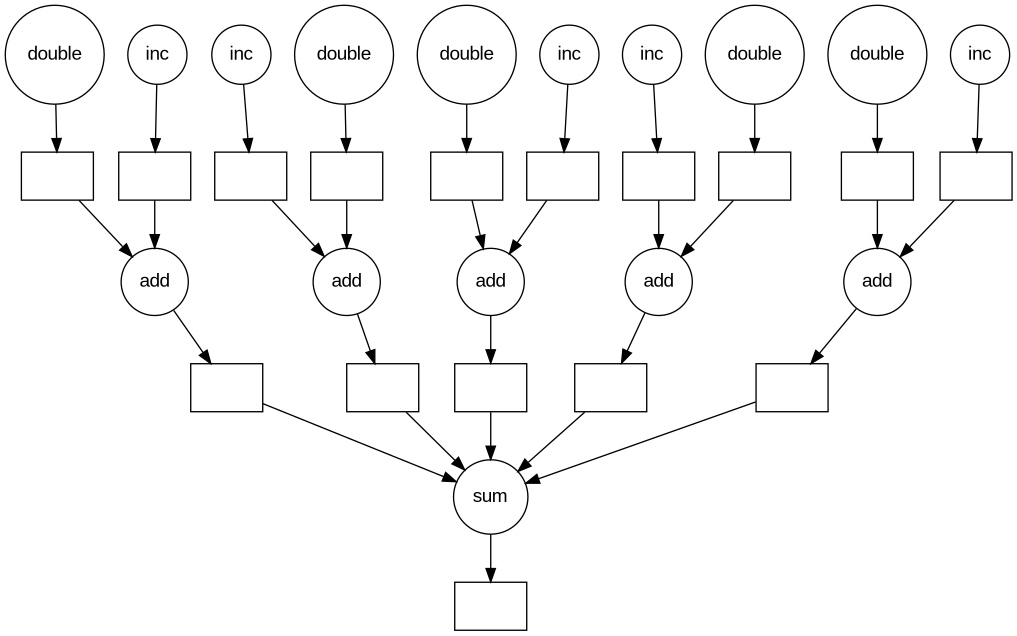

In [7]:
from dask import delayed


@delayed
def inc(x: int) -> int:
    return x + 1


@delayed
def double(x: int) -> int:
    return 2 * x


@delayed
def add(x: int, y: int) -> int:
    return x + y


with Client(cluster):
    data = [1, 2, 3, 4, 5]

    output = []
    for x in data:
        a = inc(x)
        b = double(x)
        c = add(a, b)
        output.append(c)

    total = delayed(sum)(output)

total.visualize(rankdir = "UD")

---
### Read data from S3

In [ ]:
from dask.distributed import Client
import dask.dataframe as dd
import dask.bag as db
import pandas as pd
import json
import os

BUCKET = "minikube-jupyterhub-data"

storage_options = {
    "key": os.environ["AWS_ACCESS_KEY_ID"],
    "secret": os.environ["AWS_SECRET_ACCESS_KEY"],
    "client_kwargs": {"region_name": "us-east-1"}
}

In [ ]:
with Client(cluster) as client:
    cwd = client.run(os.getcwd)
    print(cwd)

---
#### CSV

In [ ]:
with Client(cluster):
    df = dd.read_csv(
        f"s3://{BUCKET}/*.csv",
        storage_options = storage_options,
        blocksize = "64MiB"
    )

    rows = len(df)

f"{rows=:_}"

---
#### Parquet

In [ ]:
with Client(cluster):
    df = dd.read_parquet(
        f"s3://{BUCKET}/*.parquet",
        storage_options = storage_options,
        blocksize = "128MiB",
        split_row_groups = "adaptive"
    )

    result = df.groupby("VendorID")["passenger_count"].mean().compute()

result

---
#### NDJSON

In [ ]:
with Client(cluster):
    df = dd.read_json(f"s3://{BUCKET}/*.ndjson.gz", storage_options = storage_options)

df.head()

In [ ]:
with Client(cluster):
    dbag = db.read_text(
        f"s3://{BUCKET}/*.ndjson.gz",
        storage_options = storage_options
    ).map(json.loads)

with Client(cluster):
    namespace = dbag.map(lambda d: d.get("metadata", {}).get("namespace")).compute()

namespace[:5]

In [ ]:
with Client(cluster):
    filtered = dbag.filter(lambda d: d.get("metadata", {}) != {})

    filtered.map(json.dumps).to_textfiles(
        f"s3://{BUCKET}/dask/outputs/manifests.ndjson.gz",
        storage_options = storage_options
    )

In [ ]:
with Client(cluster):
    df = dbag.to_dataframe()

df.loc[:3].compute()

In [ ]:
with Client(cluster):
    print(dbag.count().compute())